In [3]:
import numpy as np
import scipy as sp
import torch
import math
from matplotlib import pyplot as plt
import pandas as pd

# torch.nn = None  # torch.nn is not allowed

data = torch.load("exercise1_data.pth", weights_only=True)

### Task 1: Simple Attention

Implement (single-head) scaled dot-product attention without projection layers, i.e. treat `x` as if it was queue, key and value.

In [4]:
def calc_attention(q: torch.tensor, k: torch.tensor, v: torch.tensor):
    n, d = q.shape
    # Formula from the slides
    return torch.softmax(((q @ k.mT) / math.sqrt(d)), dim=0) @ v

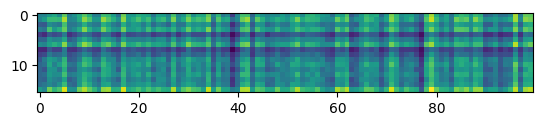

In [5]:
x = data["some_tokens"].clone()

plt.imshow(calc_attention(x, x, x))

### Task 2: Multi-head Self-Attention

Implement multi-head scaled dot-product attention with 4 heads for 32-dimensional tokens `x`. Use `W_` as the weights for query, key and value, their first dimension corresponds to the number of heads. 
Visualize the attention of each head.


In [6]:
W_q, W_k, W_v = data["mha_weights"]
W_q, W_k, W_v = W_q[0], W_k[0], W_v[0]
W_q.shape, W_k.shape, W_v.shape

(torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([16, 16]))

In [7]:
def multi_head_attention(x: torch.tensor, q, k, v):
    att = torch.tensor([])
    for i in range(4):
        # account for higher dim of CIFAR ViT data
        if x.ndim == 2:  # basic case
            att = torch.cat((att, calc_attention(q[i], k[i], v[i])), dim=1)
        else:  # CIFAR
            att = torch.cat((att, calc_attention(q[i], k[i], v[i])), dim=2)
    return x, att


def visualize(att: torch.tensor):
    fig, ax = plt.subplots(1, 4, figsize=(6, 8))
    for i in range(4):
        ax[i].imshow(att[:, 4 * i : 4 * (i + 1)])
    plt.show()

x.shape=torch.Size([16, 100])
att.shape=torch.Size([100, 16])


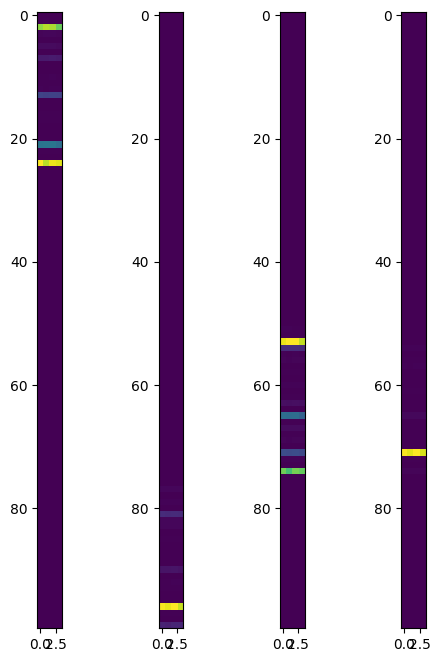

In [8]:
x = data["some_tokens"].clone()
print(f"{x.shape=}")
q = (W_q.T @ x).reshape(4, 100, 4)
k = (W_k.T @ x).reshape(4, 100, 4)
v = (W_v.T @ x).reshape(4, 100, 4)
x, att = multi_head_attention(x, q, k, v)
print(f"{att.shape=}")

visualize(att)

### Task 3: RoPE Position Embedding

Implement RoPE positional embeddings and apply them on the tokens `x`. Note, the rotations are carried out in groups of two dimensions and each group has a different rotation rate.

In [9]:
def neg_half(x: torch.tensor):
    """
    heper function for 3rd part in
    arxiv.org/pdf/2104.09864 - RoFormer
    chapter 3.4.2, formula (34)
    """
    x_reorder = torch.empty_like(x)
    x_reorder[..., ::2] = -x[..., 1::2]
    x_reorder[..., 1::2] = x[..., ::2]
    return x_reorder


def rope(x: torch.tensor, base: int = 1e4):
    # ref1: arxiv.org/pdf/2104.09864 - RoFormer
    if x.ndim == 2:  # 1D RoPE case
        n, d = x.shape
        # ref1: 3.2.2, formula (15)
        theta = base ** (-2 * torch.arange(d // 2) / d)
        # ref1: 3.4.2, formula (34)
        positions = torch.arange(n)
        # build a lookup for m*theta, sin and cos on return
        m_theta = torch.outer(positions, theta)
        m_theta_lookup = torch.cat([m_theta, m_theta], dim=1).sort().values
        return x * m_theta_lookup.cos() + neg_half(x) * m_theta_lookup.sin()

    if x.ndim == 4:  # 2D patch case
        b, px, py, d = x.shape
        # mostly same as 1D case, applied along x and y
        theta = base ** (-2 * torch.arange(d // 2) / d)
        # handle the dims seperately, could maybe be condensed
        y_positions = torch.arange(py).unsqueeze(1).expand(py, px).flatten()
        x_positions = torch.arange(px).unsqueeze(0).expand(py, px).flatten()
        # position encodings for both dims
        m_theta_x = torch.outer(x_positions, theta).view(py, px, -1)
        m_theta_y = torch.outer(y_positions, theta).view(py, px, -1)
        # lookups for x and y dim
        sin_x, cos_x = m_theta_x.sin(), m_theta_x.cos()
        sin_y, cos_y = m_theta_y.sin(), m_theta_y.cos()
        # expand lookup to batch and embed dims
        sin_x = sin_x.unsqueeze(0).repeat(b, 1, 1, 2).view(b, py, px, d)
        cos_x = cos_x.unsqueeze(0).repeat(b, 1, 1, 2).view(b, py, px, d)
        sin_y = sin_y.unsqueeze(0).repeat(b, 1, 1, 2).view(b, py, px, d)
        cos_y = cos_y.unsqueeze(0).repeat(b, 1, 1, 2).view(b, py, px, d)
        # apply rotations
        rotated_x = x * cos_x + neg_half(x) * sin_x
        rotated_y = x * cos_y + neg_half(x) * sin_y
        return rotated_x + rotated_y
    else:
        print("rope got bad shape")
        print(f"{x.shape=}")

In [10]:
# check if dims work out
# and values are not completely whacky
print(f"pre rope:\n{x.shape=}")
print(f"{x=}")
x2 = x + rope(x)
print(f"post rope:\n{x2.shape=}")
print(f"{x2=}")

pre rope:
x.shape=torch.Size([16, 100])
x=tensor([[0.6027, 0.8112, 0.0718,  ..., 0.6160, 0.9860, 0.8504],
        [0.3749, 0.9934, 0.3596,  ..., 0.5146, 0.9439, 0.6179],
        [0.1638, 0.1192, 0.3319,  ..., 0.1720, 0.5390, 0.8907],
        ...,
        [0.5768, 0.3583, 0.4596,  ..., 0.0694, 0.5270, 0.6718],
        [0.5402, 0.8482, 0.0257,  ..., 0.4025, 0.6348, 0.7333],
        [0.6154, 0.1160, 0.8269,  ..., 0.1372, 0.6145, 0.9194]])
post rope:
x2.shape=torch.Size([16, 100])
x2=tensor([[ 1.2055,  1.6225,  0.1436,  ...,  1.2320,  1.9720,  1.7008],
        [ 0.7497,  1.9868,  0.7191,  ...,  1.2734,  0.9339,  1.7460],
        [ 0.3276,  0.2384,  0.6637,  ...,  0.6851, -0.4952,  1.0101],
        ...,
        [ 1.1530,  0.7175,  0.9181,  ..., -0.7014,  0.7229,  1.5029],
        [ 1.0790,  1.6973,  0.0513,  ..., -0.1253, -0.0049,  1.4624],
        [ 1.2305,  0.2330,  1.6530,  ...,  0.2414, -0.4502,  0.6205]])


### Task 4: Transformer Architecture

- **Task 4.1**: Implement the layer norm function.
- **Task 4.2**: Implement a 2-layer MLP with ReLU non-linearity.
- **Task 4.3**: Compose this into a Transformer Layer. You can (but don't have to) use the code below. Note, since `torch.nn` is not available, we have to manage parameters manually.


![foo](https://raw.githubusercontent.com/dvgodoy/dl-visuals/main/Transformers/enc_both.png)

basic idea, for reference during network building.

In [11]:
class linear:
    def __init__(self, in_features, out_features):
        self.weight = torch.randn(out_features, in_features, requires_grad=True)
        self.bias = torch.zeros(out_features, requires_grad=True)

    def __call__(self, x):
        return x @ self.weight.t() + self.bias


class layer_norm:
    def __init__(self, embed_dim):
        self.gamma = torch.ones(embed_dim, requires_grad=True)
        self.beta = torch.zeros(embed_dim, requires_grad=True)

    def __call__(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x = (x - mean) / (std + 1e-5)
        return self.gamma * x + self.beta


class multi_attention:
    def __init__(self, embed_dim, num_heads):
        # just to check we didn't mess up params
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        # learnable weights for Q, K, V
        self.query_proj = linear(embed_dim, embed_dim)
        self.key_proj = linear(embed_dim, embed_dim)
        self.value_proj = linear(embed_dim, embed_dim)

    def __call__(self, x):
        # TODO: make compatible to task 2 so we don't nee dthis here
        batch_size, num_tokens, embed_dim = x.shape
        # project to Q, K, V
        Q = self.query_proj(x)
        K = self.key_proj(x)
        V = self.value_proj(x)
        # reshape for multi-head attention
        Q = Q.view(batch_size, num_tokens, self.num_heads, self.head_dim).permute(
            0, 2, 1, 3
        )
        K = K.view(batch_size, num_tokens, self.num_heads, self.head_dim).permute(
            0, 2, 1, 3
        )
        V = V.view(batch_size, num_tokens, self.num_heads, self.head_dim).permute(
            0, 2, 1, 3
        )
        # Scaled dot-product attention
        attn_scores = Q @ K.transpose(-2, -1) / math.sqrt(self.head_dim)
        attn_probs = torch.softmax(attn_scores, dim=-1)  # normalize
        attn_output = (
            attn_probs @ V
        )  # return shape (batch_size, num_heads, num_tokens, head_dim)
        # Combine heads, reshape
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        attn_output = attn_output.view(batch_size, num_tokens, embed_dim)
        # Final linear projection
        return attn_output


# feed forward bit in encoder
class mlp:
    def __init__(self, embed_dim, hidden_dim):
        self.fc1 = linear(embed_dim, hidden_dim)
        self.fc2 = linear(hidden_dim, embed_dim)

    def __call__(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


# transformer encoder block
class te_block:
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        self.self_attn = multi_attention(embed_dim, num_heads)
        self.feed_forward = mlp(embed_dim, hidden_dim)
        self.norm1 = layer_norm(embed_dim)
        self.norm2 = layer_norm(embed_dim)

    def __call__(self, x):
        # norm(att + skip)
        attn_output = self.self_attn(x)
        x = self.norm1(x + attn_output)
        # norm(mlp + skip)
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)
        return x


# full transformer
class custom_ViT:
    def __init__(
        self,
        num_tokens=64,
        token_dim=48,
        embed_dim=64,
        num_heads=4,
        num_classes=100,
        num_layers=3,
        hidden_dim=128,
    ):
        self.token_embedding = linear(token_dim, embed_dim)
        self.positional_encoding = torch.randn(
            1, num_tokens, embed_dim, requires_grad=True
        )
        self.encoder_layers = [
            te_block(embed_dim, num_heads, hidden_dim) for _ in range(num_layers)
        ]
        self.classifier = linear(embed_dim, num_classes)
        self.is_training = True

    def train(self):
        self.is_training = True

    def eval(self):
        self.is_training = False

    def parameters(self):
        params = []
        # embedding
        params.append(self.token_embedding.weight)
        if self.token_embedding.bias is not None:
            params.append(self.token_embedding.bias)
        # pos encoding
        params.append(self.positional_encoding)
        # encoder layers
        for layer in self.encoder_layers:
            params.extend(
                [
                    layer.self_attn.query_proj.weight,
                    layer.self_attn.query_proj.bias,
                    layer.self_attn.key_proj.weight,
                    layer.self_attn.value_proj.weight,
                    # layer.self_attn.out_proj.weight,
                    # layer.self_attn.out_proj.bias,
                    layer.norm1.gamma,
                    layer.norm1.beta,
                    layer.norm2.gamma,
                    layer.norm2.beta,
                    layer.feed_forward.fc1.weight,
                    layer.feed_forward.fc1.bias,
                    layer.feed_forward.fc2.weight,
                    layer.feed_forward.fc2.bias,
                ]
            )
        # final classifier
        params.append(self.classifier.weight)
        if self.classifier.bias is not None:
            params.append(self.classifier.bias)
        # return all parameters that require gradients
        return (p for p in params if p.requires_grad)

    def __call__(self, x):
        # Token Embedding + Positional Encoding
        # wip version while rope was being built
        # x = self.token_embedding(x) + self.positional_encoding
        x = x + rope(x)
        x = x.view(16, 64, 48).float()
        x = self.token_embedding(x)
        # go through TE blocks
        for layer in self.encoder_layers:
            x = layer(x)
        # pooling + prediction
        x = x.mean(dim=1)  # global average pooling
        x = self.classifier(x)
        return x

### Task 5: CIFAR Training

Use your network and train it on CIFAR-100. Use the cross-entropy loss function.
Use your own train/val split.

In [12]:
cifar_tokens, cifar_labels = data["cifar_tokens"], data["cifar_labels"]

In [13]:
print(cifar_tokens.shape)
# 10000 samples, each is a 8 x 8 grid of 48-dimensional tokens.
print(cifar_labels.shape)

torch.Size([10000, 8, 8, 48])
torch.Size([10000])


In [14]:
# Load data
cifar_tokens, cifar_labels = data["cifar_tokens"], data["cifar_labels"]
cifar_tokens.shape

# split into train and test sets
train_split = 0.9
batch_size = 16

train, val = torch.utils.data.random_split(
    list(zip(cifar_tokens, cifar_labels)),
    [train_split, 1 - train_split],
    generator=torch.Generator().manual_seed(42),
)
# build DataLoaders from datasets
train_loader = torch.utils.data.DataLoader(
    dataset=train, shuffle=False, batch_size=batch_size, drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val, shuffle=False, batch_size=batch_size, drop_last=True
)

In [15]:
def cross_entropy_loss(predictions, targets):
    # compute softmax in numerically stable way
    # via minmax, probably not needed anymore
    # max_logits = predictions.max(dim=1, keepdim=True).values  # Shape: [batch_size, 1]
    # min_logits = predictions.min(dim=1, keepdim=True).values
    # stable_logits = (predictions - min_logits) / (
    #    max_logits - min_logits
    # )
    return -torch.log(torch.softmax(predictions, dim=1))[
        range(len(targets)), targets
    ].mean()

In [16]:
# init model and optimizer
model = custom_ViT(num_layers=3)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

test_set = data["cifar_tokens_test"]

# prepare train/val loop
epochs = 100
train_loss = []
val_loss = []
train_acc = []
val_acc = []
batch_loss = []

for epoch in range(epochs):
    # train
    model.train()
    correct = 0
    total = 0
    epoch_train_loss = []
    for i, (tokens, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(tokens)
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    train_acc.append(100 * correct / total)
    # val
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        epoch_val_loss = []
        for tokens, labels in val_loader:
            outputs = model(tokens)
            loss = cross_entropy_loss(outputs, labels)
            epoch_val_loss.append(loss.item())
            val_predictions = torch.argmax(outputs, dim=1)
            val_correct += (val_predictions == labels).sum().item()
            val_total += labels.size(0)
    # housekeeping:
    # get loss and acc metrics for epoch
    val_acc.append(100 * val_correct / val_total)
    batch_loss += epoch_train_loss
    train_loss.append(np.mean(epoch_train_loss))
    val_loss.append(np.mean(epoch_val_loss))
    # give some live output during training
    if not epoch % 20:
        print("─" * 53)
        print("Epoch │ Train Loss │ Val Loss │ Train Acc  │ Val Acc")
        print("─" * 53)
    print(
        f"{(epoch + 1):03d}   │ {train_loss[-1]:.4f}     │ {val_loss[-1]:.4f}   │ {train_acc[-1]:7.4f}%   │ {val_acc[-1]:7.4f}%"
    )

─────────────────────────────────────────────────────
Epoch │ Train Loss │ Val Loss │ Train Acc  │ Val Acc
─────────────────────────────────────────────────────
001   │ 7.1596     │ 4.9669   │  1.0231%   │  1.0081%
002   │ 4.7597     │ 4.6900   │  1.1232%   │  1.2097%
003   │ 4.6543     │ 4.6802   │  1.3234%   │  1.1089%
004   │ 4.6305     │ 4.6526   │  1.5458%   │  1.5121%
005   │ 4.6116     │ 4.6417   │  1.7905%   │  0.8065%
006   │ 4.5840     │ 4.6155   │  2.3020%   │  1.2097%
007   │ 4.5568     │ 4.6059   │  2.6468%   │  0.9073%
008   │ 4.5163     │ 4.5630   │  2.9359%   │  1.0081%
009   │ 4.4711     │ 4.5265   │  3.2807%   │  1.8145%
010   │ 4.4213     │ 4.5073   │  3.5142%   │  1.9153%
011   │ 4.3751     │ 4.4789   │  3.8701%   │  2.5202%
012   │ 4.3334     │ 4.4475   │  4.4484%   │  3.0242%
013   │ 4.2966     │ 4.4098   │  4.7598%   │  3.5282%
014   │ 4.2685     │ 4.3827   │  5.0823%   │  3.9315%
015   │ 4.2438     │ 4.3689   │  5.6495%   │  3.4274%
016   │ 4.2072     │ 4.3527  

In [17]:
def draw_plot(data, title="", type=""):
    """
    just to make our plots slightly more appealing.
    """
    plt.plot(data)
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(type)
    plt.legend(data.columns)
    # plt.savefig(title.replace(' ','_'))

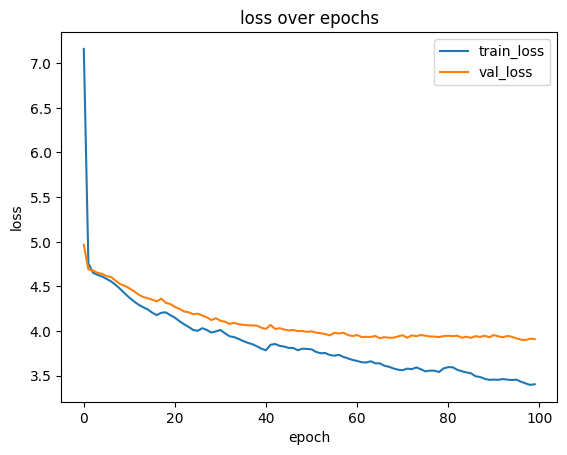

In [18]:
# check losses over all epochs
losses = pd.DataFrame({"train_loss": train_loss, "val_loss": val_loss})
draw_plot(losses, title="loss over epochs", type="loss")

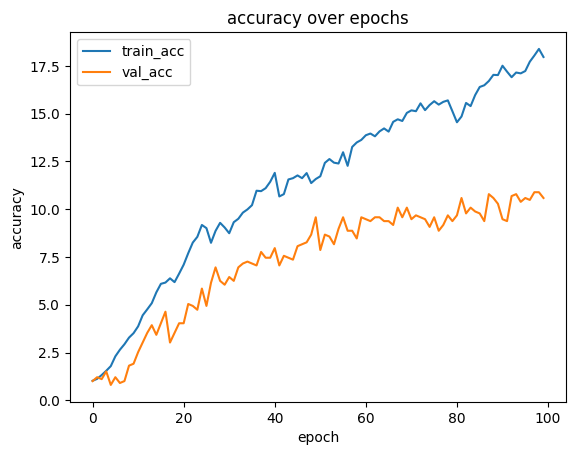

In [19]:
# same for acc
accuracy = pd.DataFrame({"train_acc": train_acc, "val_acc": val_acc})
draw_plot(accuracy, title="accuracy over epochs", type="accuracy")

## Supplement: Visualize 2D RoPE on Data

Since RoPE comes from NLP and is only recently being utilized in computer vision, there is little in terms of guides on how to apply it - or even what it does.

I tried reversing back to our training data in its original shape with and without applying rope first to see its effects.

The idea is loosely based on [this](https://towardsdatascience.com/position-embeddings-for-vision-transformers-explained-a6f9add341d5), though it does not yet deal with RoPE.

In [20]:
# get a single batch of data and target
batch_tokens = next(iter(train_loader))[0]
batch_targets = next(iter(train_loader))[1]

# perform rope on data batch
batch_tokens_rope = batch_tokens + rope(batch_tokens)

# check shapes
print("without rope:")
print(batch_tokens.shape)
print("with rope:")
print(batch_tokens.shape)

# label for a single prediction
print(f"\nour label for datapoint 0 is: {batch_targets[0,...]}")
print("this corresponds to CIFAR100 label: man")

without rope:
torch.Size([16, 8, 8, 48])
with rope:
torch.Size([16, 8, 8, 48])

our label for datapoint 0 is: 46
this corresponds to CIFAR100 label: man


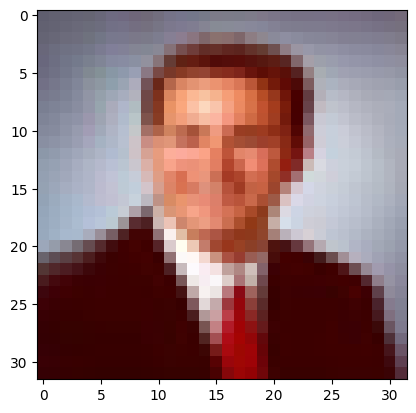

In [21]:
# reconstruct the image ffrom patches
patches = batch_tokens[0, ...].reshape(8, 8, 4, 4, 3)
re_img = patches.permute(0, 2, 1, 3, 4).reshape(8 * 4, 8 * 4, 3)
plt.imshow(re_img)
# plt.savefig('reimagined.png')

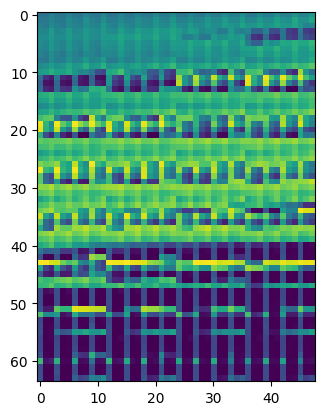

In [22]:
# same image as patches
plt.imshow(batch_tokens[0, ...].reshape(64, 48))

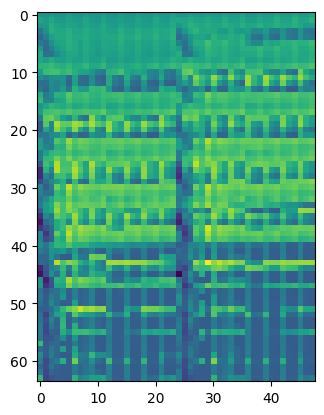

In [23]:
# the patch-image after rope
plt.imshow(batch_tokens_rope[0, ...].reshape(64, 48))

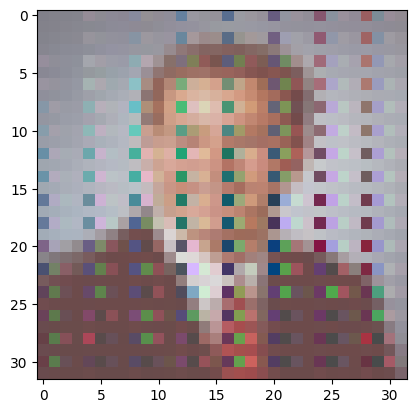

In [24]:
# finally, the reconstructed image, now after doing rope
patches = batch_tokens_rope[0, ...].reshape(8, 8, 4, 4, 3)
re_img = patches.permute(0, 2, 1, 3, 4).reshape(8 * 4, 8 * 4, 3)
# minmax to appease plt numeric constraints
plt.imshow((re_img - re_img.min()) / (re_img.max() - re_img.min()))
# plt.savefig('reimagined_with_rope.png')